### IMPORT LIBRARIES

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import convolve
from skimage.filters import roberts, sobel, scharr, prewitt, gaussian

### CONFIG

In [25]:
TRAIN_PATH = './train/train.tif'
LABEL_PATH = './labels/label.tif'
INFERENCE_PATH = './train/train.tif'
INFERENCE_LABEL = './labels/'

PRE_TRAIN = False
MODEL_PATH = './models'
MODEL_NAME = 'random_forest'
SAVE_MODEL = True

# We only infer 1 image out of 9 images in train tif stack (due to memory constraint)
# We also use train data for inference for visualizing purpose
IMAGE_INFERENCE = 7

### Leung man filter bank (deprecated due to no improvements in performance)

In [3]:
# def gaussian1d(sigma, mean, x, ord):
#     x = np.array(x)
#     x_ = x - mean
#     var = sigma**2

#     g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))
    
#     if ord == 0:
#         g = g1
#         return g
#     elif ord == 1:
#         g = -g1*((x_)/(var))
#         return g
#     else:
#         g = g1*(((x_*x_) - var)/(var**2))
#         return g

# def gaussian2d(sup, scales):
#     var = scales * scales
#     shape = (sup,sup)
#     n,m = [(i - 1)/2 for i in shape]
#     x,y = np.ogrid[-m:m+1,-n:n+1]
#     g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
#     return g

# def log2d(sup, scales):
#     var = scales * scales
#     shape = (sup,sup)
#     n,m = [(i - 1)/2 for i in shape]
#     x,y = np.ogrid[-m:m+1,-n:n+1]
#     g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
#     h = g*((x*x + y*y) - var)/(var**2)
#     return h

# def makefilter(scale, phasex, phasey, pts, sup):

#     gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
#     gy = gaussian1d(scale,   0, pts[1,...], phasey)

#     image = gx*gy

#     image = np.reshape(image,(sup,sup))
#     return image

# def makeLMfilters():
#     sup     = 49
#     scalex  = np.sqrt(2) * np.array([1,2,3])
#     norient = 6
#     nrotinv = 12

#     nbar  = len(scalex)*norient
#     nedge = len(scalex)*norient
#     nf    = nbar+nedge+nrotinv
#     F     = np.zeros([sup,sup,nf])
#     hsup  = (sup - 1)/2

#     x = [np.arange(-hsup,hsup+1)]
#     y = [np.arange(-hsup,hsup+1)]

#     [x,y] = np.meshgrid(x,y)

#     orgpts = [x.flatten(), y.flatten()]
#     orgpts = np.array(orgpts)
    
#     count = 0
#     for scale in range(len(scalex)):
#         for orient in range(norient):
#             angle = (np.pi * orient)/norient
#             c = np.cos(angle)
#             s = np.sin(angle)
#             rotpts = [[c+0,-s+0],[s+0,c+0]]
#             rotpts = np.array(rotpts)
#             rotpts = np.dot(rotpts,orgpts)
#             F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
#             F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
#             count = count + 1
            
#     count = nbar+nedge
#     scales = np.sqrt(2) * np.array([1,2,3,4])
    
#     for i in range(len(scales)):
#         F[:,:,count]   = gaussian2d(sup, scales[i])
#         count = count + 1
        
#     for i in range(len(scales)):
#         F[:,:,count] = log2d(sup, scales[i])
#         count = count + 1
        
#     for i in range(len(scales)):
#         F[:,:,count] = log2d(sup, 3*scales[i])
#         count = count + 1
        
#     return F

### Creating features

In [4]:
def feature_engineering(img, img_name, inferrence= False):
    df = pd.DataFrame()

    df['og_pixels'] = img.reshape(-1)
    df['img'] = img_name

    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.5):
                    gabor_label = 'gabor_' + str(num)
                    ksize = 9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype= cv2.CV_32F)
                    kernels.append(kernel)
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img
                    num += 1

    # F = makeLMfilters()
    # _, _, num_filters = F.shape
    # for i in range(num_filters):
    #     df[f'lm_filter_{i}'] = convolve(img, F[:,:,i], mode='same').reshape(-1)

    edges = cv2.Canny(img, 100, 200)
    edges1 = edges.reshape(-1)
    df['canny'] = edges1

    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['roberts'] = edge_roberts1

    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['sobel'] = edge_sobel1

    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['scharr'] = edge_scharr1

    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['prewitt'] = edge_prewitt1

    gaussian_img = gaussian(img, 3)
    df['gaussian_s3'] = gaussian_img.reshape(-1)

    gaussian_img2 = gaussian(img, 7)
    df['gaussian_s7'] = gaussian_img2.reshape(-1)


    median_img = cv2.medianBlur(img, 3)
    df['median_s3'] = median_img.reshape(-1)

    if inferrence:
        df = df.drop('img', axis= 1)

    return df

In [5]:
def crop_center(img, crop_amount= 100):
    center = img.shape
    w = center[1] - 100
    h = center[0] - 100
    x = center[1]/2 + 10 - w/2
    y = center[0]/2 + 5 - h/2
    return img[int(y):int(y+h), int(x):int(x+w)]

### Loading train images (total of 9)

In [6]:
train_df = pd.DataFrame()

_, train_img = cv2.imreadmulti(TRAIN_PATH, [])

for img_name, img in enumerate(train_img):
    img_name = str(img_name) + '.jpg'
    print(f'Loading {img_name}')
    img = crop_center(img)
    df = feature_engineering(img, img_name)
    train_df = pd.concat([train_df, df])
train_df


Loading 0.jpg
Loading 1.jpg
Loading 2.jpg
Loading 3.jpg
Loading 4.jpg
Loading 5.jpg
Loading 6.jpg
Loading 7.jpg
Loading 8.jpg


,og_pixels,img,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,...,gabor_31,gabor_32,canny,roberts,sobel,scharr,prewitt,gaussian_s3,gaussian_s7,median_s3
0,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827899,0,8.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
827900,0,8.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
827901,0,8.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
827902,0,8.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Loading label

In [8]:
train_label_df = pd.DataFrame()

_, train_label_img = cv2.imreadmulti(LABEL_PATH, [])

for label_name, label_img in enumerate(train_label_img):
    label_name = str(label_name) + '.jpg'
    df = pd.DataFrame()

    label_img = crop_center(label_img)
    
    df['label'] = label_img.reshape(-1)
    df['img_label'] = label_name

    train_label_df = pd.concat([train_label_df, df])
train_label_df

,label,img_label
0,0,0.jpg
1,0,0.jpg
2,0,0.jpg
3,0,0.jpg
4,0,0.jpg
...,...,...
827899,0,8.jpg
827900,0,8.jpg
827901,0,8.jpg
827902,0,8.jpg


### Loading using 4 tiff file as 4 classes (deprecated)

In [9]:
# train_label_df = pd.DataFrame()
# train_label_path = './labels/'

In [10]:
# _, label_2 = cv2.imreadmulti(os.path.join(train_label_path, 'label_2.tiff'))
# _, label_3 = cv2.imreadmulti(os.path.join(train_label_path, 'label_3.tiff'))
# _, label_4 = cv2.imreadmulti(os.path.join(train_label_path, 'label_4.tiff'))

In [11]:
# for i in range(len(label_2)):
#     img_name = str(i) + '.jpg'
#     df = pd.DataFrame()

#     label = np.where(label_2[i] != 0, 1, 0)
#     label = np.where(label_3[i] != 0, 2, label)
#     label = np.where(label_4[i] != 0, 3, label)
    
#     df['label'] = label.reshape(-1)
#     df['img_label'] = img_name
#     train_label_df = pd.concat([train_label_df, df])
# train_label_df

### Concat train data with label

In [12]:
data_df = pd.concat([train_df, train_label_df], axis= 1)

data_df['img'].equals(data_df['img_label'])

True

### Drop 0 as the 1 tiff file only need designated label of 1 to 4 to be trained

In [13]:
data_df = data_df[data_df['label'] != 0]

### Creating group index for LOGO cross validition

In [14]:
group = data_df.groupby('img').ngroup()
group

434       0
435       0
436       0
437       0
438       0
         ..
773843    8
773844    8
773845    8
773846    8
773847    8
Length: 313757, dtype: int64

### Extracting X and Y

In [15]:
X = data_df.drop(['img', 'img_label','label'], axis= 1).reset_index(drop= True)
Y = data_df['label'].values

In [16]:
X

,og_pixels,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,gabor_9,...,gabor_31,gabor_32,canny,roberts,sobel,scharr,prewitt,gaussian_s3,gaussian_s7,median_s3
0,27,0,0,71,37,13,6,0,0,0,...,51,36,0,0.061570,0.058274,0.060422,0.055490,0.104920,0.122716,24
1,34,0,0,139,84,72,46,52,34,0,...,46,32,0,0.041963,0.029248,0.028803,0.029937,0.100748,0.120607,26
2,26,0,0,112,64,19,14,0,0,0,...,23,14,0,0.024802,0.046037,0.048560,0.042679,0.098503,0.118737,24
3,15,0,0,134,59,53,20,34,11,0,...,20,12,0,0.015686,0.025110,0.027355,0.022203,0.097983,0.117126,18
4,14,0,0,140,61,36,13,2,0,0,...,24,13,0,0.039703,0.025206,0.024857,0.025682,0.098909,0.115780,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313752,154,0,0,255,255,254,146,109,66,0,...,86,55,0,0.023854,0.018653,0.018874,0.018486,0.546654,0.436508,149
313753,146,0,0,255,255,247,132,103,51,0,...,74,42,0,0.014139,0.014739,0.013660,0.016353,0.549833,0.432962,149
313754,150,0,0,255,255,226,125,86,49,0,...,66,33,0,0.011765,0.014706,0.018873,0.009150,0.551589,0.428366,149
313755,154,0,0,255,255,231,126,90,47,0,...,98,61,0,0.041595,0.034314,0.034167,0.034511,0.550889,0.422649,151


In [17]:
np.unique(Y)

array([1, 2, 3, 4], dtype=uint8)

### Creating model and cross validating

In [18]:
from sklearn.model_selection import cross_validate, cross_val_predict, LeaveOneGroupOut
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, roc_curve
from itertools import cycle

def cross_validation(model, _X, _Y, _groups, _scoring, _threads= 1):
    print('start validating')

    logo = LeaveOneGroupOut()

    y_bin = label_binarize(_Y, classes= [1, 2, 3, 4])
    n_classes = y_bin.shape[1]

    scores = cross_validate(model, _X, _Y, groups= _groups, scoring= _scoring, cv= logo, n_jobs= _threads, verbose= 1)

    y_scores = cross_val_predict(model, _X, _Y, groups= _groups, cv= logo, method= 'predict_proba')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(1, n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    classes = {
        0: 'Air',
        1: 'Clay',
        2: 'Quartz',
        3: 'Pyrite'
    }
    for i, color in zip(range(1, n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes.get(i), roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()

    result = {}
    for metric in scores:
        result[metric] = scores[metric]
        result[metric + '__mean'] = scores[metric].mean()
        result[metric + '__standard-deviation'] = scores[metric].std()
    return result

start training
start validating


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:   17.7s remaining:   22.1s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:   20.2s finished


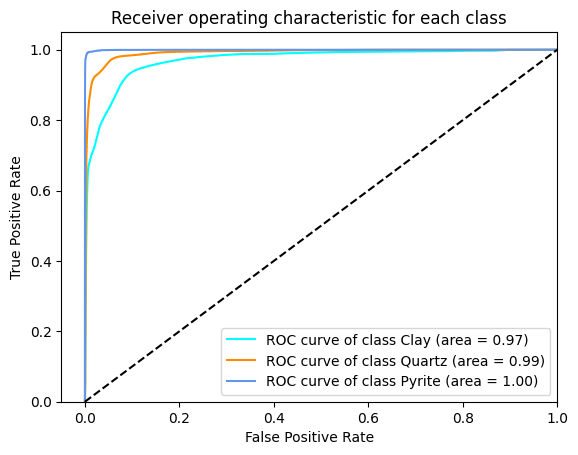

RandomForestClassifier(max_depth=8, max_leaf_nodes=8, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [19]:
from sklearn.ensemble import RandomForestClassifier
import pickle

if PRE_TRAIN:
    with open(os.path.join(MODEL_PATH, MODEL_NAME), 'rb') as f:
        model = pickle.load(f)
else:
    model = RandomForestClassifier(n_estimators= 50, min_samples_leaf= 1, min_samples_split= 2, max_depth= 8, max_leaf_nodes= 8, random_state= 42, n_jobs= -1)


    scoring = ['accuracy', 'f1_macro', 'jaccard_macro']


    print('start training')

    score = cross_validation(model, X, Y, group, scoring, 8)

    model.fit(X, Y)

### Doing inference for testing output

In [20]:
_, img_test_list = cv2.imreadmulti(INFERENCE_PATH)
img_test = img_test_list[IMAGE_INFERENCE]
img_test_df = feature_engineering(img_test, 'test.jpg', True)
img_test_df

,og_pixels,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,gabor_9,...,gabor_31,gabor_32,canny,roberts,sobel,scharr,prewitt,gaussian_s3,gaussian_s7,median_s3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [21]:
segmented_img_test = model.predict(img_test_df)
segmented_img_test = segmented_img_test.reshape((img_test.shape))

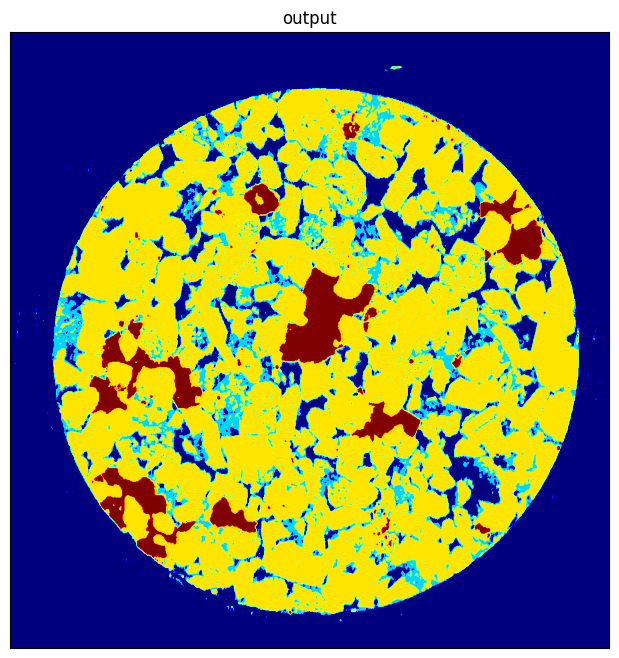

In [22]:
plt.figure(figsize=(8, 8))
fig = plt.imshow(segmented_img_test, cmap= 'jet')
plt.title('output')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [26]:
if SAVE_MODEL:
    pickle.dump(model, open(os.path.join(MODEL_PATH, MODEL_NAME), 'wb'))

In [28]:
sorted(zip(model.feature_importances_, img_test_df.columns), reverse= True)

[(0.21974652334363926, 'median_s3'),
 (0.13864189639717076, 'og_pixels'),
 (0.13861100927851913, 'gaussian_s3'),
 (0.09911901210986063, 'gaussian_s7'),
 (0.09486253749003692, 'gabor_4'),
 (0.07397464738702832, 'gabor_6'),
 (0.04371233205968542, 'gabor_3'),
 (0.03917192365533715, 'gabor_5'),
 (0.025120039310520904, 'gabor_23'),
 (0.023524086401186806, 'gabor_24'),
 (0.02201829187765041, 'gabor_7'),
 (0.018694145120186353, 'gabor_12'),
 (0.013395184241601627, 'gabor_8'),
 (0.01241078819966373, 'gabor_21'),
 (0.0099891427579435, 'gabor_29'),
 (0.006266048615015373, 'gabor_11'),
 (0.006036310189134587, 'gabor_31'),
 (0.0048605217889335145, 'scharr'),
 (0.003479310897114086, 'roberts'),
 (0.0032623013448773463, 'prewitt'),
 (0.0016279200765349545, 'sobel'),
 (0.0014354749602970914, 'gabor_20'),
 (4.055249806227037e-05, 'canny'),
 (0.0, 'gabor_9'),
 (0.0, 'gabor_32'),
 (0.0, 'gabor_30'),
 (0.0, 'gabor_28'),
 (0.0, 'gabor_27'),
 (0.0, 'gabor_26'),
 (0.0, 'gabor_25'),
 (0.0, 'gabor_22'),
 (0.0

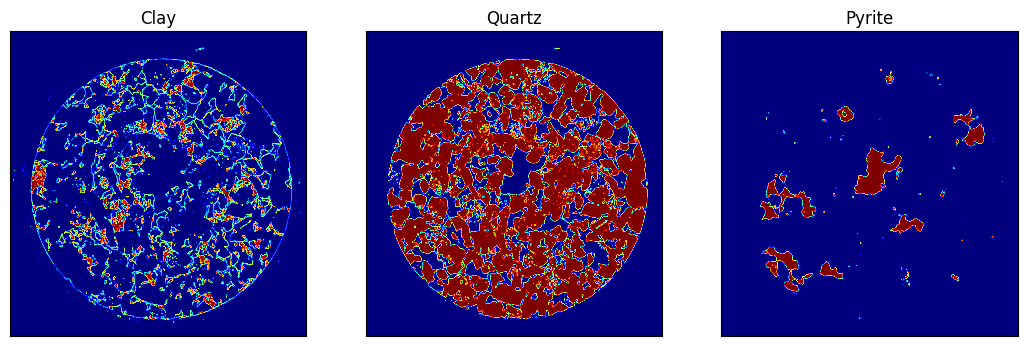

In [29]:
plt.figure(figsize= (13, 13))
label_list = {
    1: 'Air',
    2: 'Clay',
    3: 'Quartz',
    4: 'Pyrite'
}
for i in range(3):
    plt.subplot(1, 3, i + 1)
    fig = plt.imshow(segmented_img_test == i + 2, cmap= 'jet')
    fig = plt.title(label_list.get(i + 2))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    